### Import all the required packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision import transforms, utils, datasets, models
from torch.autograd import Variable
from keras.optimizers import Adam
import glob
import os
import numpy as np 
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pathlib

2023-03-28 21:39:21.689175: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 21:39:22.323833: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-28 21:39:22.323881: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-28 21:39:22.323886: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

### Import Dataset

In [2]:
path = pathlib.Path("Rice_Image_Dataset")

In [3]:
arborio = list(path.glob('Arborio/*'))
basmati = list(path.glob('Basmati/*'))
ipsala = list(path.glob('Ipsala/*'))
jasmine = list(path.glob('Jasmine/*'))
karacadag = list(path.glob('Karacadag/*'))

total_list=arborio + basmati + ipsala + jasmine + karacadag

In [4]:
# The photos we have are 250 x 250 pixels and each one is 3D. 
# We have a total of 75,000 photos, which are divided into 15,000 collections

In [6]:
data_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor()
    ]
)

model_dataset = datasets.ImageFolder(path, transform=data_transform) 

image, label = model_dataset[1]
print(f"Image Size: {image.shape}")
print(f"Label: {label}")
print(image)

Image Size: torch.Size([3, 250, 250])
Label: 0
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


In [7]:
data_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((100,100)),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]
        ),
    ]
)
BATCH_SIZE=256

model_dataset = datasets.ImageFolder(path, transform=data_transform) 
train_count = int(0.7 * len(total_list)) 
valid_count = int(0.2 * len(total_list))
test_count = len(total_list) - train_count - valid_count
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(model_dataset, (train_count, valid_count, test_count))
train_dataset_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)  
valid_dataset_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True) 
test_dataset_loader  = torch.utils.data.DataLoader(test_dataset , batch_size=BATCH_SIZE, shuffle=False)
dataloaders = {'train': train_dataset_loader, 'val': valid_dataset_loader, 'test': test_dataset_loader}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


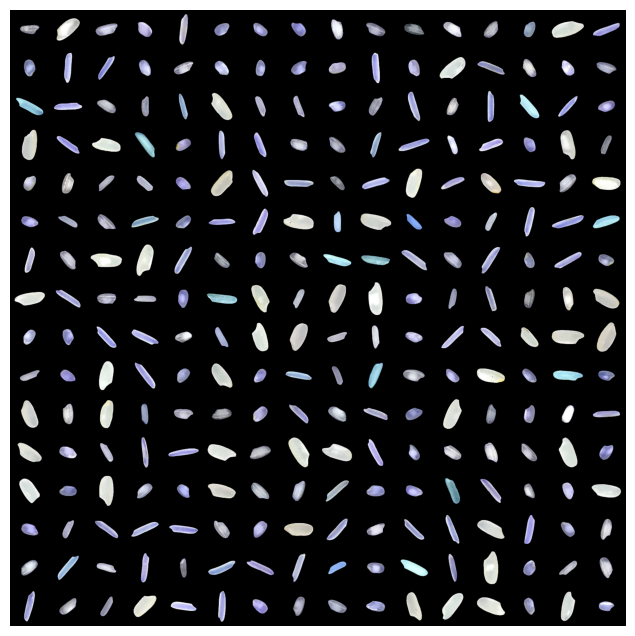

In [8]:
for item in train_dataset_loader:
    plt.figure(figsize=(16, 8))
    image, _ = item
    plt.imshow(make_grid(image, nrow=16).permute(1, 2, 0))
    plt.axis("off")
    plt.show()
    break

In [9]:
class CustomizedConvNet(nn.Module):
    def __init__(self,number_of_classes):
        super().__init__() #Inheritance
        
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=12,padding=1,kernel_size=3)
        self.bn1=nn.BatchNorm2d(num_features=12)
        self.relu1=nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(in_channels=12,out_channels=20,padding=1,kernel_size=3)
        self.bn2=nn.BatchNorm2d(num_features=20)
        self.relu2=nn.ReLU()
        
        self.conv3 = nn.Conv2d(in_channels=20,out_channels=32,padding=1,kernel_size=3)
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.relu3=nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        

        self.fc1=nn.Linear(32*25*25, 5)

    
    def forward(self, Input):
        
        output=self.conv1(Input)
        output=self.bn1(output)
        output=self.relu1(output)
        output=self.pool1(output)
        
        output=self.conv2(output)
        output=self.bn2(output)
        output=self.relu2(output)
        
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
        output=self.pool3(output)
    
        
        output = torch.flatten(output, 1)
        output = output.view(-1,32*25*25)
        output=self.fc1(output)

        
        return output

In [10]:
model = CustomizedConvNet(5)
device = 'cpu'
model = model.to(device)
model

CustomizedConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=20000, out_features=5, bias=True)
)

In [11]:
def accuracy(pred, label):
    _, out = torch.max(pred, dim=1)
    return torch.tensor(torch.sum(out == label).item()/len(pred))

def validation_step(valid_dl, model, loss_fn):
    for image, label in valid_dl:
        out = model(image)
        loss = loss_fn(out, label)
        acc = accuracy(out, label)
        return {"val_loss": loss, "val_acc": acc}
def fit_to_model(train_dl, valid_dl, epochs, optimizer, loss_fn, model):
    history = []
    for epoch in range(epochs):
        for image, label in train_dl:
            out = model(image)
            loss = loss_fn(out, label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            
        val = validation_step(valid_dl, model, loss_fn)
        print(f"Epoch [{epoch}/{epochs}] => loss: {loss}, val_loss: {val['val_loss']}, val_acc: {val['val_acc']}")
        history.append({"loss": loss, 
                        "val_loss": val['val_loss'], 
                        "val_acc": val['val_acc']
                       })
    return history
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for x in self.dl:
            yield to_device(x, self.device)


In [12]:
train_dataset_loader= DeviceDataLoader(train_dataset_loader, device)
valid_dataset_loader = DeviceDataLoader(valid_dataset_loader, device)

In [13]:
Loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 7
history = fit_to_model(train_dataset_loader, valid_dataset_loader, epochs, optimizer, Loss, model)

Epoch [0/7] => loss: 0.053561437875032425, val_loss: 0.04044030234217644, val_acc: 0.98828125
Epoch [1/7] => loss: 0.01550801657140255, val_loss: 0.06713371723890305, val_acc: 0.98828125
Epoch [2/7] => loss: 0.018963774666190147, val_loss: 0.03954843804240227, val_acc: 0.9921875
Epoch [3/7] => loss: 0.0023159889969974756, val_loss: 0.01212175004184246, val_acc: 1.0
Epoch [4/7] => loss: 0.010020861402153969, val_loss: 0.012749417684972286, val_acc: 0.99609375
Epoch [5/7] => loss: 0.0019682690035551786, val_loss: 0.00939256977289915, val_acc: 0.99609375
Epoch [6/7] => loss: 0.005976303014904261, val_loss: 0.008035555481910706, val_acc: 1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


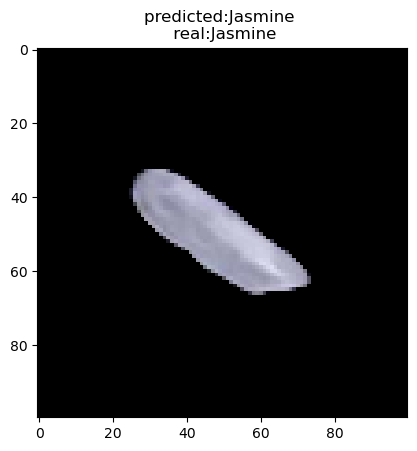

In [14]:
model = model.cpu()
with torch.no_grad():
    
    for img,label in test_dataset_loader:
        imgs = img[5]
        labels = label[5]
        output_model = imgs.unsqueeze(0)
        output_model = model(output_model)
        index = output_model.argmax()
        imgs = torch.permute(imgs,(1,2,0))
        plt.imshow(imgs)
        plt.title(f"predicted:{ model_dataset.classes[index]} \n real:{ model_dataset.classes[labels]}")
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


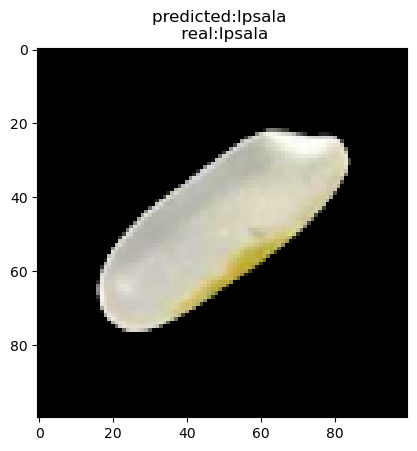

In [15]:
for i, (img, label) in enumerate(test_dataset_loader):
    if i >= 5:
        break
    imgs = img[i]
    labels = label[i]
    output_model = imgs.unsqueeze(0)
    output_model = model(output_model)
    index = output_model.argmax()
    imgs = torch.permute(imgs,(1,2,0))
    plt.imshow(imgs)
    plt.title(f"predicted:{ model_dataset.classes[index]} \n real:{ model_dataset.classes[labels]}")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


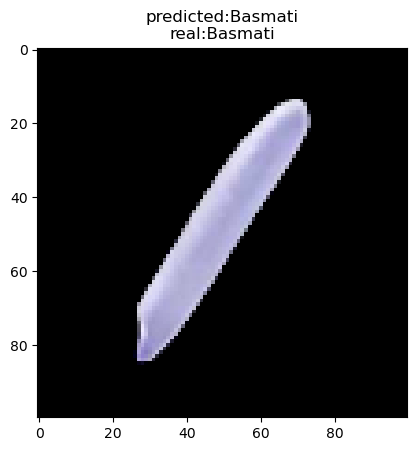

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


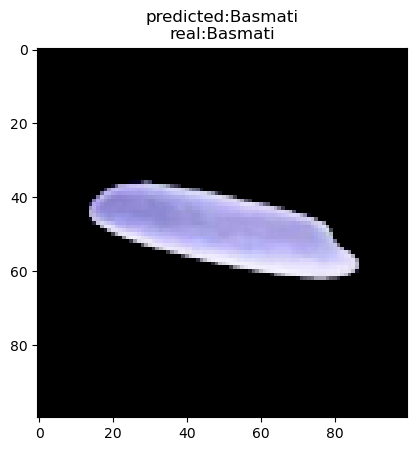

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


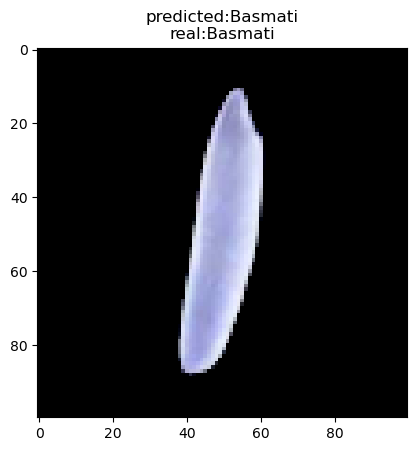

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


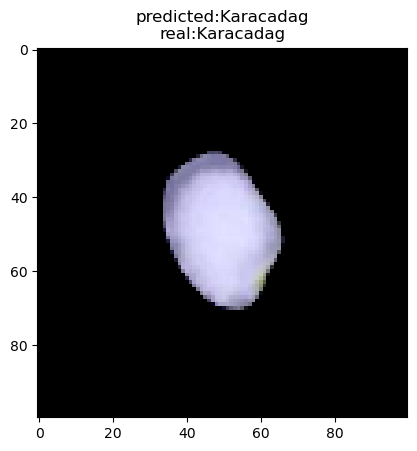

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


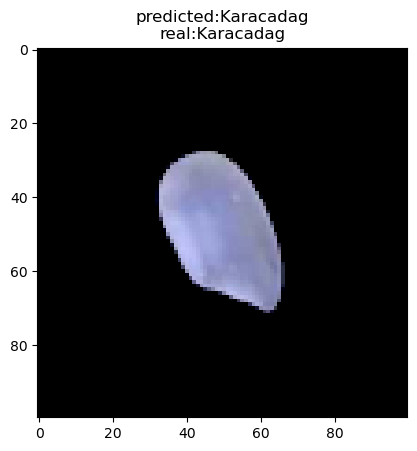

In [16]:
model = model.cpu()

with torch.no_grad():
    for img, label in test_dataset_loader:
        imgs = img[:5]
        labels = label[:5]
        output_model = model(imgs)
        indices = output_model.argmax(dim=1)
        for i in range(5):
            img_i = imgs[i].permute(1, 2, 0)
            plt.imshow(img_i)
            plt.title(f"predicted:{model_dataset.classes[indices[i]]}\nreal:{model_dataset.classes[labels[i]]}")
            plt.show()
        break


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


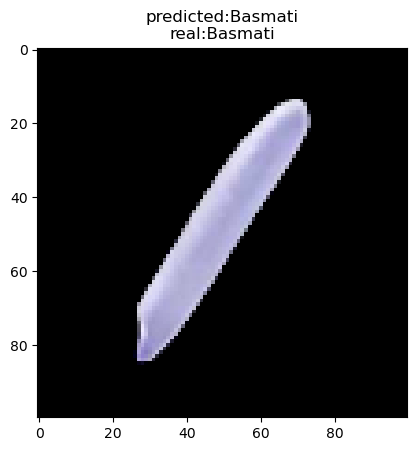

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


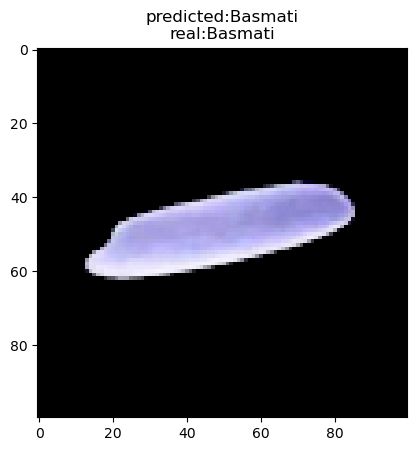

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


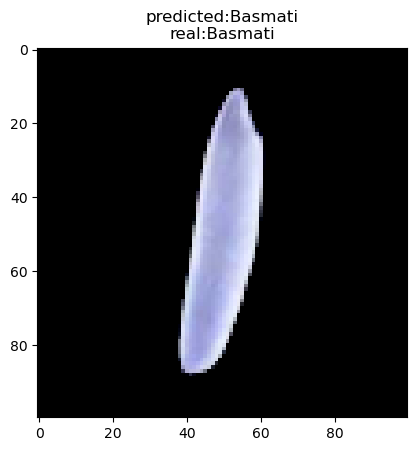

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


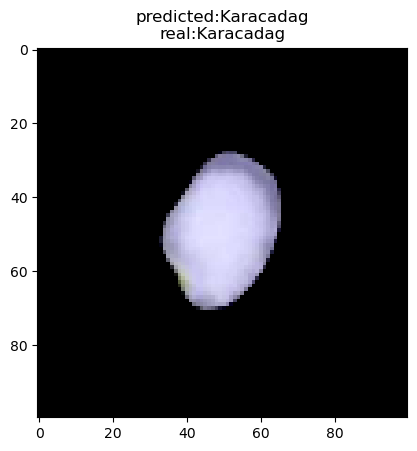

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


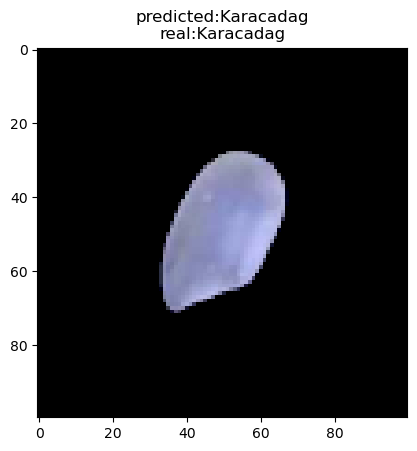

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


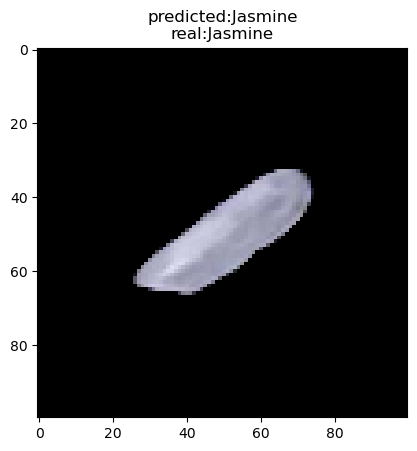

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


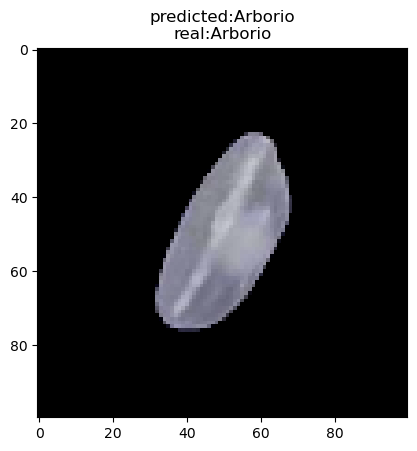

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


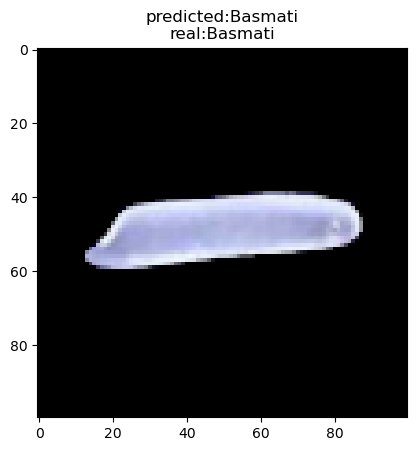

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


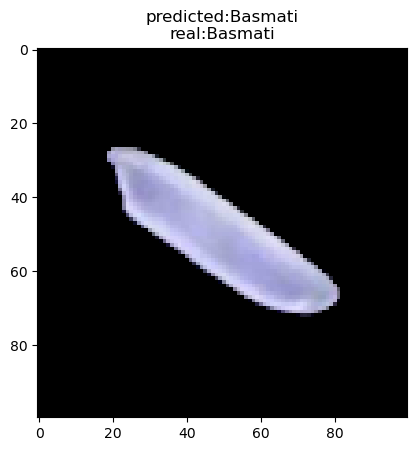

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


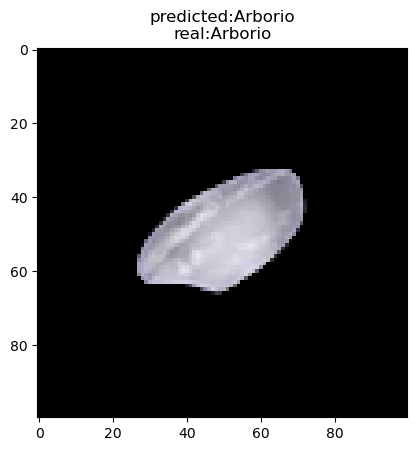

In [19]:
model = model.cpu()

with torch.no_grad():
    for img, label in test_dataset_loader:
        imgs = img[:10]
        labels = label[:10]
        output_model = model(imgs)
        indices = output_model.argmax(dim=1)
        for i in range(10):
            img_i = imgs[i].permute(1, 2, 0)
            plt.imshow(img_i)
            plt.title(f"predicted:{model_dataset.classes[indices[i]]}\nreal:{model_dataset.classes[labels[i]]}")
            plt.show()
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


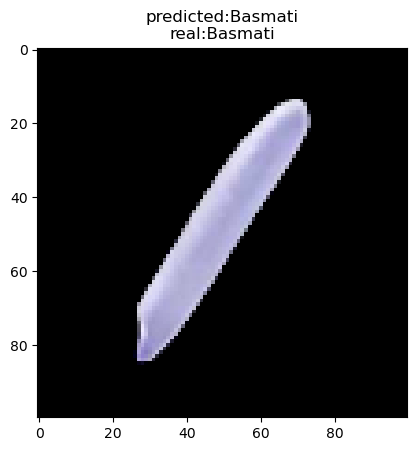

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


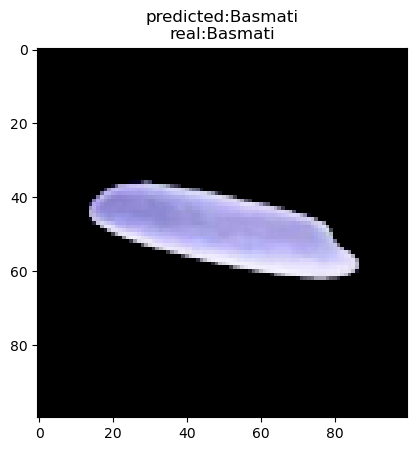

In [22]:
model = model.cpu()

with torch.no_grad():
    for img, label in test_dataset_loader:
        imgs = img[:2]
        labels = label[:2]
        output_model = model(imgs)
        indices = output_model.argmax(dim=1)
        for i in range(2):
            img_i = imgs[i].permute(1, 2, 0)
            plt.imshow(img_i)
            plt.title(f"predicted:{model_dataset.classes[indices[i]]}\nreal:{model_dataset.classes[labels[i]]}")
            plt.show()
        break